## CACTI Radars Analysis: Cross-sections:

**Radar data cross-section plotting and analysis test codes.**

* Use wrf-python module to do cross-sections.

**Hungjui Yu 20220511**

In [24]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [25]:
import sys
import time
import datetime as dt
from netCDF4 import Dataset # MFDataset
import numpy as np
from scipy.interpolate import interpn
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.img_tiles as cimgt

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ( from_levels_and_colors, Normalize ) 


from metpy.plots import ctables
import metpy.calc as mpcalc


In [26]:
from wrf import ( getvar, interplevel, to_np, get_cartopy, latlon_coords, vertcross
                , cartopy_xlim, cartopy_ylim, interpline, CoordPair, WrfProj
                , xy_to_ll_proj
                )

### Open radar data from local:

In [ ]:
test_method = 'SAMURAI'
test_time = dt.datetime(2019, 1, 25, 22, 0, 0)

# ds_radar = xr.open_dataset('/Users/yuhungjui/Downloads/samurai_XYZ_analysis_m.nc')
ds_radar = xr.open_dataset('/Users/yuhungjui/Downloads/samurai_XYZ_analysis.nc')

### Open radar data on Maui:

In [27]:
data_path_1 = '/home/hyu/2scratch2/DATA_DOE_CACTI_cases'

#### from SAMURAI:

In [28]:
test_method = 'SAMURAI'
test_time = dt.datetime(2019, 1, 25, 22, 0, 0)
# test_time = dt.datetime(2018, 12, 14, 2, 30, 0)

# test_output = '2ppi'
# test_output = '2ppi_1rhi_2hsrhi_snd'
# test_output = '2ppi_2rhi_2hsrhi'
test_output = 'VEL_deA5_RMA1_2210'

data_path_2_met = '/test_{}'.format(test_method)
data_path_3_dt = '/test_{}'.format(test_time.strftime('%Y%m%d_%H%M%S')) + '_QC_dealias'

data_path_full = data_path_1 \
               + data_path_2_met \
               + data_path_3_dt \
               + '/output_' + test_output + '/samurai_XYZ_analysis.nc'
               
ds_radar = xr.open_dataset(data_path_full)

#### from FRACTL:

In [94]:
test_method = 'FRACTL'
test_time = dt.datetime(2019, 1, 25, 22, 0, 0)
# test_time = dt.datetime(2018, 12, 14, 2, 30, 0)

data_path_2_met = '/test_{}'.format(test_method)
data_path_3_dt = '/test_{}'.format(test_time.strftime('%Y%m%d_%H%M%S')) + '_QC_dealias_onMac'

data_path_full = data_path_1 \
               + data_path_2_met \
               + data_path_3_dt \
               + '/output_VEL_deA5/{}'.format(test_time.strftime('%Y%m%d')) \
               + '/ncf_20190125_221051.nc'
               
ds_radar = xr.open_dataset(data_path_full)

#### from Datasets:

In [42]:
test_dataset = 'CSAPR2'

data_path_2 = '/2CSAPR2_intp/ppi/20190125/20190125_220003.mdv.cf.nc'

data_path_full = data_path_1 + data_path_2
               
ds_radar = xr.open_dataset(data_path_full)

#### from EVAD:

In [ ]:
# ds_radar = xr.open_dataset('/home/hyu/2scratch2/DATA_DOE_CACTI_cases/test_EVAD/output/20190125/profile.20190125_180003.CSAPR2.nc')

In [29]:
ds_radar

<xarray.Dataset>
Dimensions:     (longitude: 201, latitude: 201, altitude: 51, time: 1)
Coordinates:
  * longitude   (longitude) float32 -66.12 -66.1 -66.07 ... -61.93 -61.9 -61.88
  * latitude    (latitude) float32 -33.8 -33.79 -33.77 ... -30.23 -30.21 -30.2
  * altitude    (altitude) float32 0.0 0.5 1.0 1.5 2.0 ... 23.5 24.0 24.5 25.0
  * time        (time) datetime64[ns] 2019-01-25T22:00:00
Data variables: (12/53)
    x           (longitude) float32 ...
    y           (latitude) float32 ...
    U           (time, altitude, latitude, longitude) float32 ...
    V           (time, altitude, latitude, longitude) float32 ...
    W           (time, altitude, latitude, longitude) float32 ...
    WSPD        (time, altitude, latitude, longitude) float32 ...
    ...          ...
    DQVDZ       (time, altitude, latitude, longitude) float32 ...
    DPDZ        (time, altitude, latitude, longitude) float32 ...
    DRHODX      (time, altitude, latitude, longitude) float32 ...
    DRHODY      (time, altitude, latitude, longitude) float32 ...
    DRHODZ      (time, altitude, latitude, longitude) float32 ...
    MCRESIDUAL  (time, altitude, latitude, longitude) float32 ...

### Open WRF output for terrain:

In [30]:
# ter = getvar( Dataset('/home/hyu/Research_Test/Radar_analysis_CACTI/Data_Terrain/wrf_1km_terrain.nc')
#             , 'HGT'
#             , timeidx=0
#             , meta=False)

ter = xr.open_dataset('/home/hyu/Research_work/Radar_analysis_CACTI/Data_Terrain/wrf_1km_terrain.nc')

# ter

### Set data arrays:

#### for SAMURAI:

In [31]:
ds_radar_re=ds_radar.squeeze()

## Get variables:
da_DBZ = ds_radar_re['DBZ']
da_U = ds_radar_re['U']
da_V = ds_radar_re['V']
da_W = ds_radar_re['W']

## Mesh Lat/Lon:
lon, lat = np.meshgrid( ds_radar_re.longitude, ds_radar_re.latitude )

#### from FRACTL:

In [97]:
ds_radar_re=ds_radar.squeeze()

## Get variables:
da_DBZ = ds_radar_re['DBZ']
da_U = ds_radar_re['U']
da_V = ds_radar_re['V']
da_W = ds_radar_re['W']

## Mesh Lat/Lon:
lon = ds_radar_re['lon0']
lat = ds_radar_re['lat0']

#### for Datasets:

In [170]:
# ds_radar_re=ds_radar.squeeze()

# ## Get variables:
# da_DBZ = ds_radar_re['DZ_qc']

# # da_DBZ

# lat, lon = xy_to_ll_proj( da_DBZ.x0
#                         , da_DBZ.y0
#                         , meta=False
#                         , map_proj=6
#                         , stand_lon=0
#                         , ref_lat=ds_radar.attrs['radar_latitude']
#                         , ref_lon=ds_radar.attrs['radar_longitude']
#                         , known_x=0.0
#                         , known_y=0.0
#                         , pole_lat=90
#                         , pole_lon=0
#                         , dx=1000
#                         , dy=1000
#                         )


# da_DBZ['lat'] = (('y0'), lat)
# da_DBZ['lon'] = (('x0'), lon)

# # da_DBZ

# ## Mesh Lat/Lon:
# lon, lat = np.meshgrid( lon, lat )

### Plot: Cross-sections using WRF-Python:

#### Calculate linear DBZ:

In [32]:
da_LDBZ = 10**(da_DBZ/10.)
# da_LDBZ

#### Generate 3-D z data:

In [33]:
if test_method == 'SAMURAI':
    ## from SAMURAI:
    z_data = ds_radar_re.altitude.data
    z_data_3d = np.tile(z_data[:, np.newaxis, np.newaxis], (1, 201, 201))
elif test_method == 'FRACTL':
    ## from FRACTL:
    z_data = ds_radar_re.z0.data
    z_data_3d = np.tile(z_data[:, np.newaxis, np.newaxis], (1, 201, 201))
    z_data_3d = z_data_3d/1e3
else:
    ## Datasets:
    z_data = ds_radar_re.z0.data
    z_data_3d = np.tile(z_data[:, np.newaxis, np.newaxis], (1, 221, 221))

z_data_3d.shape

(51, 201, 201)

#### Function: Find the nearest grid locations to the desired point:

In [34]:
def xy_point_loc_from_grid_latlon(grid_lon, grid_lat, lon, lat):
    abslon = np.abs(grid_lon-lon)
    abslat = np.abs(grid_lat-lat)
    c = np.maximum(abslon, abslat)
    ([xloc], [yloc]) = np.where(c == np.min(c))
    
    # print(c)
    # print(np.min(c))
    # print(np.where(c == np.min(c)))
    
    return xloc, yloc

#### Set cross-section parameters:

In [35]:
## Set the LON/LAT for cross-section Start/End points:

## 2019-01-25:2200:
xsec1_LON = [-65.0, -63.7]
xsec1_LAT = [-32.6, -31.2]
xsec2_LON = [-64.6, -63.1]
xsec2_LAT = [-31.0, -32.2]

## 2018-12-14:0230:
# xsec1_LON = [-64.8, -63.6]
# xsec1_LAT = [-33, -31.0]
# xsec1_LON = [-65.3, -63.5]
# xsec1_LAT = [-31.2, -32.4]

#### Define the cross-section start and end points to nearest X, Y locations:

In [36]:
xsec_LON = xsec2_LON
xsec_LAT = xsec2_LAT

loc_start = xy_point_loc_from_grid_latlon(lon, lat, xsec_LON[0], xsec_LAT[0])
loc_end = xy_point_loc_from_grid_latlon(lon, lat, xsec_LON[1], xsec_LAT[1])

## !!! REMEMBER TO SWITCH X, Y TO GET THE CORRECT LAT/LON !!!
cross_start = CoordPair(x=loc_start[1], y=loc_start[0])
cross_end = CoordPair(x=loc_end[1], y=loc_end[0])

#### Compute the vertical cross-section (from X, Y):

In [37]:
DBZ_xsec = vertcross( da_LDBZ # Use linear Z for interpolation
                    , z_data_3d #ds_radar_re.z.data
                    , start_point=cross_start
                    , end_point=cross_end
                    )

DBZ_xsec = 10.0 * np.log10(DBZ_xsec) # Convert back to dBZ after interpolation

#### Compute cross-section for winds:

In [38]:
## Vertical winds:
W_xsec = vertcross( da_W
                  , z_data_3d #ds_radar_re.z.data
                  , start_point=cross_start
                  , end_point=cross_end
                  )

## Horizontal winds:
U_xsec = vertcross( da_U
                  , z_data_3d #ds_radar_re.z.data
                  , start_point=cross_start
                  , end_point=cross_end
                  )

V_xsec = vertcross( da_V
                  , z_data_3d #ds_radar_re.z.data
                  , start_point=cross_start
                  , end_point=cross_end
                  )

#### Get lat/lon coordinate for the cross section line:

In [39]:
xsec_lon = interpline( lon
                     # , wrfin=wrf_file
                     , start_point=cross_start
                     , end_point=cross_end
                     )
xsec_lat = interpline( lat
                     # , wrfin=wrf_file
                     , start_point=cross_start
                     , end_point=cross_end
                     )

#### Get xlabels Lat/Lon:

In [62]:
# coord_pairs = to_np(DBZ_xsec.coords["xy_loc"])
# xlabels_latlon = [pair.xy_str() for pair in coord_pairs]
# xlabels_latlon
# coord_pairs[0].xy_str()

#### Calculate the terrain line associated with the cross-section:

In [40]:
## Define the cross-section start and end points to nearest X, Y locations:
ter_loc_start = xy_point_loc_from_grid_latlon(ter.XLONG.data, ter.XLAT.data, xsec_LON[0], xsec_LAT[0])
ter_loc_end = xy_point_loc_from_grid_latlon(ter.XLONG.data, ter.XLAT.data, xsec_LON[1], xsec_LAT[1])

## !!! REMEMBER TO SWITCH X, Y TO GET THE CORRECT LAT/LON !!!
ter_cross_start = CoordPair(x=ter_loc_start[1], y=ter_loc_start[0])
ter_cross_end = CoordPair(x=ter_loc_end[1], y=ter_loc_end[0])

## Get the terrain height along the cross section line:
ter_line = interpline( ter.HGT.data
                     # , wrfin=wrf_file
                     , start_point=ter_cross_start
                     , end_point=ter_cross_end
                     )


### Plot 1: Cross-section:

#### Function: Creating new map:

In [41]:
def new_xsec(fig):
    
    # axis_color = xsec_line2_color
    
    ax = plt.axes()
    
    ax.set_xticks([0, xsec_lon.size-1])
    ax.set_xticklabels( # ['A', 'B']
                        ['C', 'D']
                        # ['SW', 'NE'] 
                        # ['NW', 'SE']
                        # ['W', 'E']
                      , fontsize=14
                      , fontweight='bold'
                      # , color=axis_color
                      # , rotation = 45
                      , ha='right' # horizontalalignment
                      )
    
#     ax.set_xticks(np.arange(0, xsec_lon.size, 5))
#     ax.set_xticklabels( np.arange(0, xsec_lon.size, 5)
#                       , fontsize=12
#                       , fontweight='bold'
#                       )
    
    ax.set_ylim([-0.5, 25])
    ax.set_yticks(np.arange(0, 26, 2))
    ax.set_yticklabels( np.arange(0, 26, 2)
                      , fontsize=14
                      , fontweight='bold'
                      )
    
    # ax.spines['bottom'].set_color(axis_color)
    # ax.spines['bottom'].set_linewidth(2.5)
    
    return ax

#### Plot dBZ:

In [42]:
## Set NWS reflectivity colorbar:
from metpy.plots import ctables
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSStormClearReflectivity', -20, 0.5)

## Set CWB reflectivity colorbar:
clevs = [-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,85]
ccols = ['#ffffff','#98ffff','#009aff','#1919ff','#19ff19','#19cd19','#19A019','#fefe08','#ffcb00','#ff9c00','#fe0005','#c90200','#9d0000','#9a009d','#cf00d7','#ff00f7','#fdcafe']
# clevs = [-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,85]
# ccols = ['#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#98ffff','#009aff','#1919ff','#19ff19','#19cd19','#19A019','#fefe08','#ffcb00','#ff9c00','#fe0005','#c90200','#9d0000','#9a009d','#cf00d7','#ff00f7','#fdcafe']

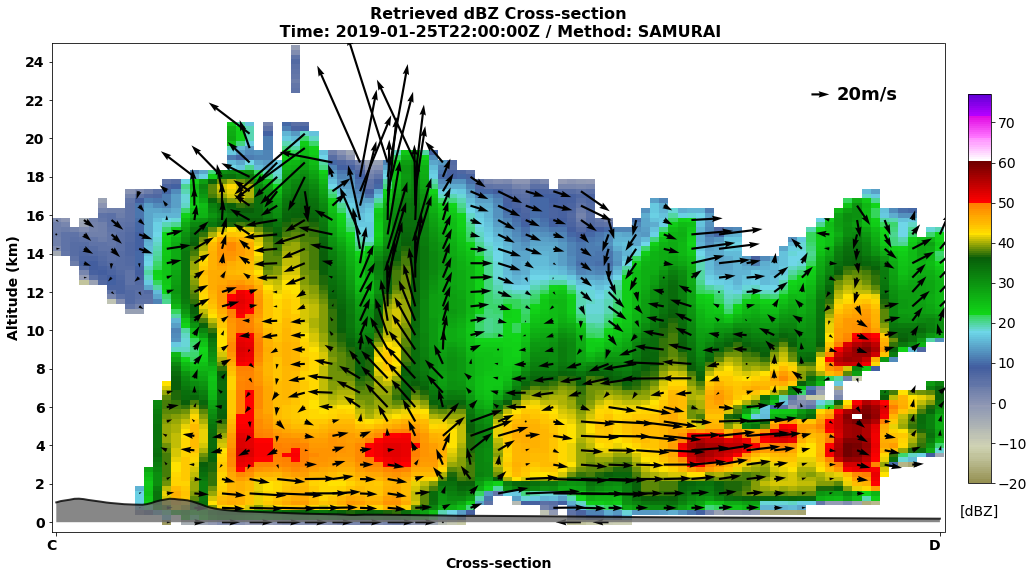

In [43]:
fig_xsec = plt.figure(figsize=(16,9))
ax_xsec = new_xsec(fig_xsec)

if test_method == 'SAMURAI':
    ## from SAMURAI:
    plotting_var = DBZ_xsec
    plotting_x = np.arange(DBZ_xsec.xy_loc.size)
    plotting_y = DBZ_xsec.vertical.data
elif test_method == 'FRACTL':
    ## from FRACTL:
    plotting_var = DBZ_xsec
    plotting_x = np.arange(DBZ_xsec.xy_loc.size)
    plotting_y = DBZ_xsec.vertical.data
else:
    # from Datasets:
    plotting_var = DBZ_xsec
    plotting_x = np.arange(DBZ_xsec.dim_0.size)
    plotting_y = DBZ_xsec.dim_1.data

## CWB colorbar (xarray plot):
# cf2 = dbz_xsec.plot.contourf( vmin=0, vmax=80, levels=clevs, colors=ccols)

## CWB colorbar:
# cf1 = ax_xsec.contourf( plotting_x, plotting_y, plotting_var
#                       , levels=clevs
#                       , colors=ccols
#                       # , vmin=0
#                       # , vmax=20
#                       )

## NWS colorbar:
cf1 = ax_xsec.pcolormesh( plotting_x, plotting_y, plotting_var
                        , cmap=ref_cmap
                        , norm=ref_norm
                        , shading='auto'
                        )

## Plot winds using the axes interface directly, barbs less crowded.
step = 3
cf_q = ax_xsec.quiver( plotting_x[::step], plotting_y[::step]
                     , U_xsec[::step, ::step] + V_xsec[::step, ::step]
                     , W_xsec[::step, ::step]
                     , scale=1000
                     # , color='dimgrey'
                     )
cf_qk = ax_xsec.quiverkey( cf_q
                         , 0.8, 0.8
                         , 20
                         , '20m/s'
                         , labelpos='E'
                         , coordinates='figure'
                         , fontproperties={'size': 18, 'weight': 'bold'}
                         )

plt.xlabel('Cross-section', {'size': 14, 'weight': 'bold'})
plt.ylabel('Altitude (km)', {'size': 14, 'weight': 'bold'})

## Plot & Fill in the terrain:
ter_line_plot = ax_xsec.plot( np.linspace(0,DBZ_xsec.xy_loc.size-1,ter_line.size)
                            , ter_line/1e3
                            , color='k'
                            , linewidth=2.0
                            , alpha=0.8
                            # , linestyle='--'
                            )
ter_fill = ax_xsec.fill_between( np.linspace(0,DBZ_xsec.xy_loc.size-1,ter_line.size)
                               , 0
                               , ter_line/1e3
                               , facecolor='dimgrey'
                               , alpha=0.8
                               )

cf1_title = plt.title( 'Retrieved dBZ Cross-section'
                     # + test_time.strftime('%Y-%m-%d T%H:%M:%SZ') 
                     + '\n Time: ' + np.datetime_as_string(ds_radar.time.data[0], unit='s') + 'Z'
                     + ' / Method: ' + test_method
                     ,fontsize=16
                     ,fontweight='bold'
                     )

cbar_ax = fig_xsec.add_axes([0.92, 0.2, 0.02, 0.6])
cbar = fig_xsec.colorbar(cf1, fraction=0.04, cax=cbar_ax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[dBZ]', fontsize=14, y=-0.1) #fontweight='bold'


## Save figure:
plt.savefig( test_time.strftime('%Y%m%d_%H%M%S')
             # './' + ds_radar.time.data[0].astype('datetime64[s]').item().strftime('%Y%m%d_%H%M%S')
           + '_' + test_method
           + '_xsec_DBZ.png'
           , bbox_inches='tight'
           , dpi=300
           )




#### Plot W:

In [44]:
## W Colormap settings:
w_bounds = np.arange(-16, 17, 2)
w_cmap = cm.get_cmap('RdBu_r', w_bounds.size+1)
w_norm = mpl.colors.BoundaryNorm(w_bounds, w_cmap.N, extend='both')


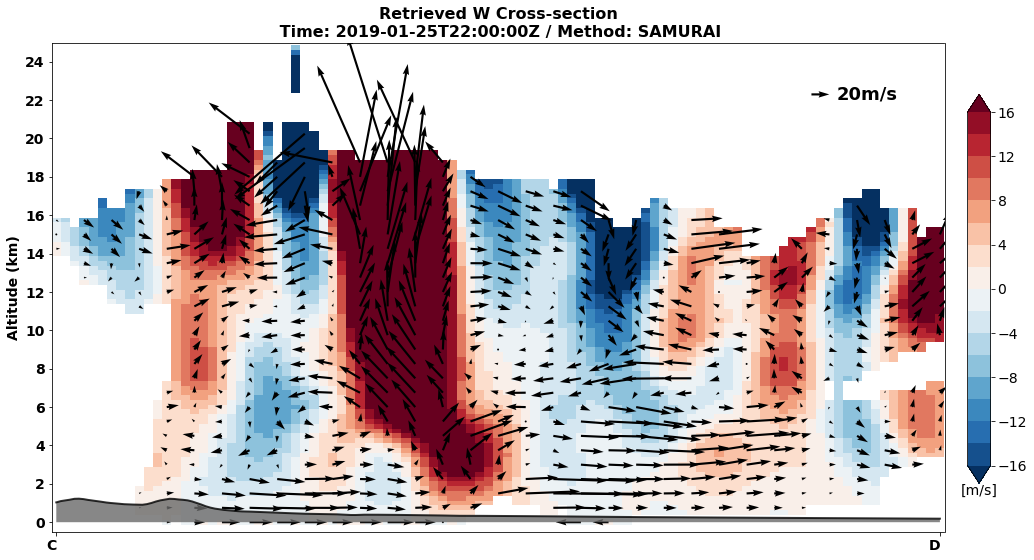

In [45]:
fig_xsec = plt.figure(figsize=(16,9))
ax_xsec = new_xsec(fig_xsec)

if test_method == 'SAMURAI':
    ## from SAMURAI:
    plotting_var = W_xsec.data
    plotting_x = np.arange(W_xsec.xy_loc.size)
    plotting_y = W_xsec.vertical.data
else:
    ## from FRACTL:
    plotting_var = W_xsec.data
    plotting_x = np.arange(W_xsec.xy_loc.size)
    plotting_y = W_xsec.vertical.data

cf1 = ax_xsec.pcolormesh( plotting_x, plotting_y, plotting_var
                      , cmap=w_cmap
                      , norm=w_norm
                      # , alpha=0.8
                      , shading='auto'
                      )

## Plot winds using the axes interface directly, barbs less crowded.
step = 3
cf_q = ax_xsec.quiver( plotting_x[::step], plotting_y[::step]
                     , U_xsec[::step, ::step] + V_xsec[::step, ::step]
                     , W_xsec[::step, ::step]
                     , scale=1000
                     # , color='dimgrey'
                     )
cf_qk = ax_xsec.quiverkey( cf_q
                         , 0.8, 0.8
                         , 20
                         , '20m/s'
                         , labelpos='E'
                         , coordinates='figure'
                         , fontproperties={'size': 18, 'weight': 'bold'}
                         )

plt.ylabel('Altitude (km)', {'size': 14, 'weight': 'bold'})

## Plot the sigmal level line:
# xsec_color = xsec_line2_color

# sigma_lev_h = ax_xsec.plot( plotting_x, sigma_line
#                           , color=xsec_color)

# ax_xsec.legend( sigma_lev_h, ['$\sigma$-level: ' + str(sigma_lev)]
#               , loc='upper left'
#               # , fontsize=14
#               , prop={'size':14, 'weight':'bold'}
#               )

## Plot & Fill in the terrain:
ter_line_plot = ax_xsec.plot( np.linspace(0,DBZ_xsec.xy_loc.size-1,ter_line.size)
                            , ter_line/1e3
                            , color='k'
                            , linewidth=2.0
                            , alpha=0.8
                            # , linestyle='--'
                            )
ter_fill = ax_xsec.fill_between( np.linspace(0,DBZ_xsec.xy_loc.size-1,ter_line.size)
                               , 0
                               , ter_line/1e3
                               , facecolor='dimgrey'
                               , alpha=0.8
                               )

cf1_title = plt.title( 'Retrieved W Cross-section'
                     # + test_time.strftime('%Y-%m-%d T%H:%M:%SZ') 
                     + '\n Time: ' + np.datetime_as_string(ds_radar.time.data[0], unit='s') + 'Z'
                     + ' / Method: ' + test_method
                     ,fontsize=16
                     ,fontweight='bold'
                     )

cbar_ax = fig_xsec.add_axes([0.92, 0.2, 0.02, 0.6])
cbar = fig_xsec.colorbar(cf1, fraction=0.04, cax=cbar_ax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[m/s]', fontsize=14, y=-0.1) #fontweight='bold'


## Save figure:
plt.savefig( test_time.strftime('%Y%m%d_%H%M%S')
             # './' + ds_radar.time.data[0].astype('datetime64[s]').item().strftime('%Y%m%d_%H%M%S')
           + '_' + test_method
           + '_xsec_W.png'
           , bbox_inches='tight'
           , dpi=300
           )




### <font color='teal'>**Supplement Codes:**</font>

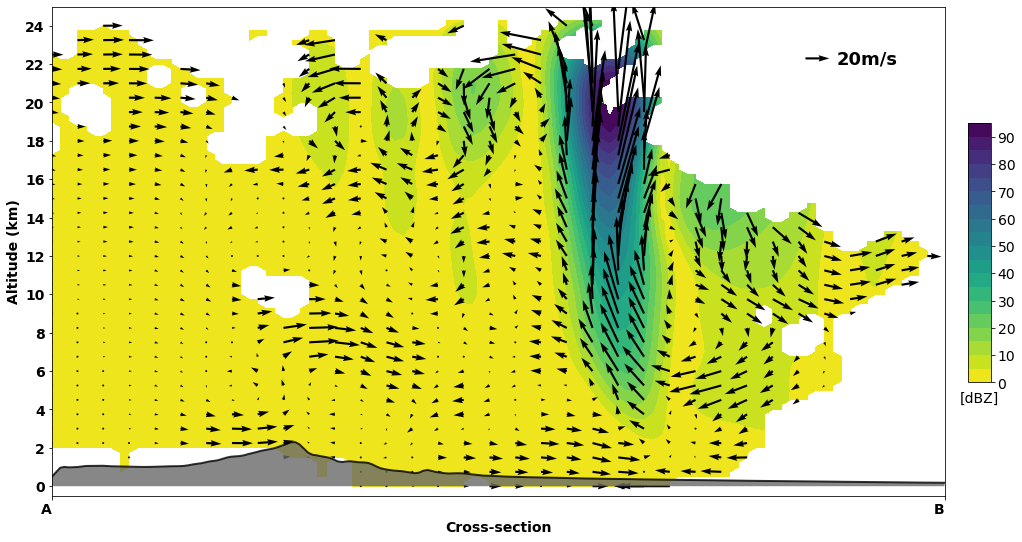

In [151]:
fig_xsec = plt.figure(figsize=(16,9))
ax_xsec = new_xsec(fig_xsec)

plotting_var = np.sqrt( (U_xsec+V_xsec)**2 + W_xsec**2 )
plotting_x = np.arange(DBZ_xsec.xy_loc.size)
plotting_y = DBZ_xsec.vertical.data
# plotting_x = np.arange(DBZ_xsec.dim_0.size)
# plotting_y = DBZ_xsec.dim_1.data

## CWB colorbar (xarray plot):
# cf2 = dbz_xsec.plot.contourf( vmin=0, vmax=80, levels=clevs, colors=ccols)

## CWB colorbar:
cf1 = ax_xsec.contourf( plotting_x, plotting_y, plotting_var
                      , cmap=cm.get_cmap('viridis_r')
                      , levels=np.arange(0,100,5)
                      # , colors=ccols
                      # , vmin=0
                      # , vmax=105
                      )

## NWS colorbar:
# cf2 = ax_xsec.pcolormesh( plotting_x, plotting_y, plotting_var
#                         , cmap=ref_cmap
#                         , norm=ref_norm
#                         , shading='auto'
#                         )

## Plot winds using the axes interface directly, barbs less crowded.
step = 3
cf_q = ax_xsec.quiver( plotting_x[::step], plotting_y[::step]
                     , U_xsec[::step, ::step] + V_xsec[::step, ::step]
                     , W_xsec[::step, ::step]
                     )
cf_qk = ax_xsec.quiverkey( cf_q
                         , 0.8, 0.8
                         , 20
                         , '20m/s'
                         , labelpos='E'
                         , coordinates='figure'
                         , fontproperties={'size': 18, 'weight': 'bold'}
                         )

plt.xlabel('Cross-section', {'size': 14, 'weight': 'bold'})
plt.ylabel('Altitude (km)', {'size': 14, 'weight': 'bold'})

## Plot & Fill in the terrain:
ter_line_plot = ax_xsec.plot( np.linspace(0,DBZ_xsec.xy_loc.size-1,ter_line.size)
                            , ter_line/1e3
                            , color='k'
                            , linewidth=2.0
                            , alpha=0.8
                            # , linestyle='--'
                            )
ter_fill = ax_xsec.fill_between( np.linspace(0,DBZ_xsec.xy_loc.size-1,ter_line.size)
                               , 0
                               , ter_line/1e3
                               , facecolor='dimgrey'
                               , alpha=0.8
                               )

# cf1_title = plt.title( 'Retrieved dBZ Cross-section'
#                      # + test_time.strftime('%Y-%m-%d T%H:%M:%SZ') 
#                      + '\n Time: ' + np.datetime_as_string(ds_radar.time.data[0], unit='s') + 'Z'
#                      + ' / Method: ' + test_method
#                      ,fontsize=16
#                      ,fontweight='bold'
#                      )

cbar_ax = fig_xsec.add_axes([0.92, 0.3, 0.02, 0.4])
cbar = fig_xsec.colorbar(cf1, fraction=0.04, cax=cbar_ax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[dBZ]', fontsize=14, y=-0.1) #fontweight='bold'


## Save figure:
# plt.savefig( test_time.strftime('%Y%m%d_%H%M%S')
#              # './' + ds_radar.time.data[0].astype('datetime64[s]').item().strftime('%Y%m%d_%H%M%S')
#            + '_xsec_DBZ.png'
#            , bbox_inches='tight'
#            , dpi=300
#            )
plt.savefig( 'test_1.png'
           , bbox_inches='tight'
           , dpi=300
           )


### Plot 1: Maps:

#### Set plotting parameters:

In [ ]:
plot_alt = 2.5 #km

#### Function: Creating new map:

In [ ]:
def new_map(fig):
    
    # proj = ccrs.LambertConformal( central_longitude=0.0, central_latitude=30, globe=None )
    # proj = ccrs.LambertCylindrical( central_longitude=0.0, globe=None )
    proj = ccrs.PlateCarree( central_longitude=0, globe=None)
    
    # ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax = plt.axes(projection=proj)
    
    ## Add background image:
    # ax.stock_img()
    
    ## Add Stamen terrain:
    stamen_terrain = cimgt.Stamen('terrain')
    
    ax.add_image(stamen_terrain, 8)
    
    ## Set extent:
    # ax.set_global()
    
    ## S. America:
    # ax.set_extent([-30, -90, 20, -60], crs=proj)
    ## CACTI:
    # ax.set_extent([-61.5, -67, -28.5, -34.5], crs=proj)
    ax.set_extent([-62.5, -66.5, -29.5, -33.5], crs=proj)
    # ax.set_extent([-62.5, -66, -29.5, -33.5], crs=proj)
    # ax.set_extent([-55, -75, -20, -40], crs=proj)
    
    ## Add coast lines:
    ax.coastlines('10m', 'black', linewidth=1)
    
    ## Grab state shapefile:
    state_borders = cfeat.NaturalEarthFeature( category='cultural' # 'physical'
                                             , name='admin_1_states_provinces_lines'
                                             # , name='geography_regions_elevation_points'
                                             , scale='50m'
                                             , facecolor='none'
                                             , edgecolor='gray'
                                             )
    ## Add features:
    # ax.add_feature(cfeat.BORDERS)
    # ax.add_feature(cfeat.LAND)
    # ax.add_feature(cfeat.COASTLINE)
    # ax.add_feature(cfeat.OCEAN, edgecolor=None) #, fc='none')
    # ax.add_feature(cfeat.GSHHSFeature(scale='auto', levels=None))
    # ax.add_feature(state_borders, linewidth=0.8)
    
    ## Add the gridlines:
    latlon_grid_int = 1
    ax_gl = ax.gridlines( crs=ccrs.PlateCarree()
                        , linewidth=0.5
                        , color='#454545' 
                        , alpha=0.9
                        , linestyle='--'
                        , draw_labels=True 
                        , dms=True
                        # , x_inline=False 
                        # , y_inline=False
                        , xlocs=np.arange(-180, 181, latlon_grid_int)
                        , ylocs=np.arange(-90, 91, latlon_grid_int)
                        )
    ax_gl.top_labels = False
    ax_gl.right_labels = False
    ax_gl.bottom_labels = True
    ax_gl.left_labels = True
    ax_gl.xlabel_style = {'size': 14, 'weight': 'bold'}
    ax_gl.ylabel_style = {'size': 14, 'weight': 'bold'}
    
    
    return ax

#### Plot dBZ:

In [ ]:
## Set NWS reflectivity colorbar:
from metpy.plots import ctables
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSStormClearReflectivity', -20, 0.5)

## Set CWB reflectivity colorbar:
clevs = [-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,85]
ccols = ['#ffffff','#98ffff','#009aff','#1919ff','#19ff19','#19cd19','#19A019','#fefe08','#ffcb00','#ff9c00','#fe0005','#c90200','#9d0000','#9a009d','#cf00d7','#ff00f7','#fdcafe']
# clevs = [-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,85]
# ccols = ['#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#98ffff','#009aff','#1919ff','#19ff19','#19cd19','#19A019','#fefe08','#ffcb00','#ff9c00','#fe0005','#c90200','#9d0000','#9a009d','#cf00d7','#ff00f7','#fdcafe']

In [ ]:
np.datetime_as_string(ds_radar.time.data[0], unit='s')

In [ ]:
fig = plt.figure(figsize=(10,10))
ax1 = new_map(fig)
# ax1 = plt.axes(projection = ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
# ax1 = plt.axes(projection = ccrs.PlateCarree())

plotting_var = ds_radar.DBZ.sel(altitude=plot_alt).data[0]
plotting_lon = ds_radar.longitude
plotting_lat = ds_radar.latitude


## CWB colorbar:
cf1 = ax1.contourf( plotting_lon, plotting_lat, plotting_var
                  , levels=clevs, colors=ccols
                  , alpha=0.6
                  )

## NWS colorbar:
# cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var
#                     , cmap=ref_cmap, norm=ref_norm
#                     , alpha=0.8
#                     , shading='auto'
#                     )
# cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var
#                     , vmax=70
#                     , vmin=-5
#                     , cmap=ctables.registry.get_colortable('NWSReflectivity')
#                     # , norm=Normalize(-5, 75)
#                     )

## Loc. CSAPR2:
plt.plot( -64.73, -32.13
        # , color='k'
        , marker='o'
        , markersize=10
        , mec='k'
        , mew=3
        , mfc='none'
        # , markevery=[0,-1]
        # , linewidth=1.0
        # , linestyle='--'
        )

## Loc. CHIVO:
plt.plot( -64.17, -31.63
        # , color='k'
        , marker='o'
        , markersize=12
        , mec='k'
        , mew=1
        , mfc='k'
        # , markevery=[0,-1]
        # , linewidth=1.0
        # , linestyle='--'
        )

cf1_title = plt.title( 'Retrieved dBZ'
                     # + test_time.strftime('%Y-%m-%d T%H:%M:%SZ') 
                     + '\n Time: ' + np.datetime_as_string(ds_radar.time.data[0], unit='s') + 'Z'
                     + ' / Height: ' + str(plot_alt) + '-km'
                     + ' \n Method: ' + test_method
                     ,fontsize=14 
                     ,fontweight='bold'
                     )

cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.4])
cbar = fig.colorbar(cf1, cax=cbar_ax, fraction=0.04)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('[dBZ]', fontsize=12, y=-0.1)


## Save figure:

# plt.savefig('./' + np.datetime_as_string(dbz_lev.Time.data, unit='h') + '_dbz_xline.png', 
#             bbox_inches='tight', 
#             dpi=300)



#### Plot W:

In [ ]:
## W Colormap settings:
w_bounds = np.arange(-4, 4.1, 0.5)
w_cmap = cm.get_cmap('RdBu_r', w_bounds.size+1)
w_norm = mpl.colors.BoundaryNorm(w_bounds, w_cmap.N, extend='both')


In [ ]:
fig = plt.figure(figsize=(9,16))
ax1 = new_map(fig)
# ax1 = plt.axes(projection = ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
# ax1 = plt.axes(projection = ccrs.PlateCarree())

plotting_var = ds_radar.W.sel(altitude=2.5).data[0]
plotting_lon = ds_radar.longitude
plotting_lat = ds_radar.latitude


cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var
                    , cmap=w_cmap
                    , norm=w_norm
                    , alpha=0.8
                    , shading='auto')


## Loc. CSAPR2:
plt.plot( -64.73, -32.13
        # , color='k'
        , marker='o'
        , markersize=14
        , mec='k'
        , mew=1
        , mfc='k'
        # , markevery=[0,-1]
        # , linewidth=1.0
        # , linestyle='--'
        )

## Loc. CHIVO:
plt.plot( -64.17, -31.63
        # , color='k'
        , marker='o'
        , markersize=14
        , mec='k'
        , mew=1
        , mfc='k'
        # , markevery=[0,-1]
        # , linewidth=1.0
        # , linestyle='--'
        )

## Plot cross-section lines:
plt.plot( [-63.5, -65.5], [-31.5, -33]
        , color='green'
        , marker='.'
        , markersize=14
        # , mec='k'
        # , mew=1
        # , mfc='k'
        , markevery=[0,-1]
        , linewidth=2.0
        , linestyle='--'
        )

cf1_title = plt.title( 'Retrieved W'
                     # + test_time.strftime('%Y-%m-%d T%H:%M:%SZ') 
                     + '\n Time: ' + np.datetime_as_string(ds_radar.time.data[0], unit='s') + 'Z'
                     + ' / Height: ' + str(plot_alt) + '-km'
                     + ' \n Method: ' + test_method
                     ,fontsize=14 
                     ,fontweight='bold'
                     )

cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.4])
cbar = fig.colorbar(cf1, cax=cbar_ax, fraction=0.04)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('[m/s]', fontsize=12, y=-0.1)


## Save figure:

# plt.savefig('./' + np.datetime_as_string(dbz_lev.Time.data, unit='h') + '_dbz_xline.png', 
#             bbox_inches='tight', 
#             dpi=300)


### <font color='dodgerblue'>**Supplement Codes from Marqi:**</font>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from astropy.convolution import convolve, Gaussian2DKernel
import pyart
from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain, 
                            csu_dsd, csu_kdp, csu_misc, fundamentals)
import csu_radartools
import matplotlib.colors as colors
import difflib
import os
from datetime import datetime


In [ ]:
print (csu_radartools.__version__)

In [ ]:
def two_panel_plot(radar, sweep=0, var1='reflectivity', vmin1=0, vmax1=70,
                   cmap1='pyart_HomeyerRainbow', units1='dBZ', var2='differential_reflectivity',
                   vmin2=-5, vmax2=5, cmap2='RdYlBu_r', units2='dB', return_flag=False,
                   xlim=[-150,150], ylim=[-150,150]):
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize=(18,5))
    fig.patch.set_facecolor('xkcd:white')
    ax1 = fig.add_subplot(121)
    display.plot_rhi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1, 
                     colorbar_label=units1, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    ax2 = fig.add_subplot(122)
    display.plot_rhi(var2, sweep=sweep, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                     colorbar_label=units2, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    if return_flag:
        return fig, ax1, ax2, display

In [ ]:
#radarfile = '/home/mrocque/research/relampago/csapr2/corcsapr2cfrppiqcM1.b1.20181214.030003.custom.nc2'
radarfile = '/home/mrocque/research/relampago/csapr2/corcsapr2cfrppiqcM1.b1.20181214.140003.custom.nc1'
#radarfile = '/rasmussen-scratch/krasmussen/DATA/RELAMPAGO/CSAPR2/ppi/20181214/corcsapr2cfrppiqcM1.b1.20181214.141504.custom.nc'
#radarfile = '/rasmussen-scratch/krasmussen/DATA/RELAMPAGO/CSAPR2/ppi/20181214/corcsapr2cfrppiqcM1.b1.20181214.234504.custom.nc'
#radarfile = '/home/mrocque/research/relampago/csapr2/corcsapr2cfrhsrhiqcM1.b1.20181214.030715.custom.nc2'
radar = pyart.io.read(radarfile)
print(radar.fields.keys())

dz = radar.fields['DZ_qc']['data']
dr = radar.fields['ZDR_qc']['data']
kd = radar.fields['PHIDP_qc']['data']
rh = radar.fields['RHOHV_qc']['data']

In [ ]:
del radar.fields['uncorrected_reflectivity_v']

In [ ]:
print (radar.fields.keys())

In [ ]:
snd_times = []
filenames = []
for filename in os.listdir('/rasmussen-scratch/mrocque/research/relampago/CACTI_ARM_soundings/netcdf/'):
    filenames.append(filename)
    str2 = (filename[18:33])
    snd_times.append(datetime.strptime(str2, '%Y%m%d.%H%M%S'))


In [ ]:
filenames.sort()
snd_times.sort()

In [ ]:
print (snd_times)

In [ ]:
#str1 = radarfile[63:78]
str1 = radarfile[88:103]
print (str1)

#closest = difflib.get_close_matches(str1, snd_times, 1)
#print (snd_times.index(closest[0]))

In [ ]:
dt_obj = datetime.strptime(str1, '%Y%m%d.%H%M%S')

res = min(snd_times, key=lambda sub: abs(sub - dt_obj))


In [ ]:
print (dt_obj)

In [ ]:
print (res)
print (snd_times.index(res))

In [ ]:
print (filenames[339])

In [ ]:
#584
#707

print (filenames[340])

In [ ]:
sndfile = '/rasmussen-scratch/mrocque/research/relampago/CACTI_ARM_soundings/netcdf/corsondewnpnM1.b1.20181214.000000.custom.cdf'

data = Dataset(sndfile, 'r')
print (data.variables.keys())
temp = np.array(data.variables['tdry'])
hght = np.array(data.variables['alt'])

In [ ]:
print (data.variables['base_time'])

In [ ]:
def radar_coords_to_cart(rng, az, ele, debug=False):
    """
    TJL - taken from old Py-ART version
    Calculate Cartesian coordinate from radar coordinates
    Parameters
    ----------
    rng : array
        Distances to the center of the radar gates (bins) in kilometers.
    az : array
        Azimuth angle of the radar in degrees.
    ele : array
        Elevation angle of the radar in degrees.
    Returns
    -------
    x, y, z : array
        Cartesian coordinates in meters from the radar.
    Notes
    -----
    The calculation for Cartesian coordinate is adapted from equations
    2.28(b) and 2.28(c) of Doviak and Zrnic [1]_ assuming a
    standard atmosphere (4/3 Earth's radius model).
    .. math::
        z = \\sqrt{r^2+R^2+r*R*sin(\\theta_e)} - R
        s = R * arcsin(\\frac{r*cos(\\theta_e)}{R+z})
        x = s * sin(\\theta_a)
        y = s * cos(\\theta_a)
    Where r is the distance from the radar to the center of the gate,
    :math:\\theta_a is the azimuth angle, :math:\\theta_e is the
    elevation angle, s is the arc length, and R is the effective radius
    of the earth, taken to be 4/3 the mean radius of earth (6371 km).
    References
    ----------
    .. [1] Doviak and Zrnic, Doppler Radar and Weather Observations, Second
        Edition, 1993, p. 21.
    """
    theta_e = ele * np.pi / 180.0  # elevation angle in radians.
    theta_a = az * np.pi / 180.0  # azimuth angle in radians.
    R = 6371.0 * 1000.0 * 4.0 / 3.0  # effective radius of earth in meters.
    r = rng * 1000.0  # distances to gates in meters.

    z = (r ** 2 + R ** 2 + 2.0 * r * R * np.sin(theta_e)) ** 0.5 - R
    s = R * np.arcsin(r * np.cos(theta_e) / (R + z))  # arc length in m.
    x = s * np.sin(theta_a)
    y = s * np.cos(theta_a)
    return x, y, z


def get_z_from_radar(radar):
    """Input radar object, return z from radar (km, 2D)"""
    azimuth_1D = radar.azimuth['data']
    elevation_1D = radar.elevation['data']
    srange_1D = radar.range['data']
    sr_2d, az_2d = np.meshgrid(srange_1D, azimuth_1D)
    el_2d = np.meshgrid(srange_1D, elevation_1D)[1]
    xx, yy, zz = radar_coords_to_cart(sr_2d/1000.0, az_2d, el_2d)
    return zz + radar.altitude['data']

def check_sounding_for_montonic(sounding):
    """
    So the sounding interpolation doesn't fail, force the sounding to behave
    monotonically so that z always increases. This eliminates data from
    descending balloons.
    """
    snd_T = np.array(sounding.variables['tdry'])
    snd_z = np.array(sounding.variables['alt'])
    
    #snd_T = sounding.soundingdata['temp']  # In old SkewT, was sounding.data
    #snd_z = sounding.soundingdata['hght']  # In old SkewT, was sounding.data
    dummy_z = []
    dummy_T = []
    #if not snd_T.mask[0]: #May cause issue for specific soundings
    dummy_z.append(snd_z[0])
    dummy_T.append(snd_T[0])
    for i, height in enumerate(snd_z):
        if i > 0:
            if snd_z[i] > snd_z[i-1]:# and not snd_T.mask[i]:
                dummy_z.append(snd_z[i])
                dummy_T.append(snd_T[i])
    snd_z = np.array(dummy_z)
    snd_T = np.array(dummy_T)
    return snd_T, snd_z


def interpolate_sounding_to_radar(sounding, radar):
    """Takes sounding data and interpolates it to every radar gate."""
    radar_z = get_z_from_radar(radar)
    radar_T = None
    snd_T, snd_z = check_sounding_for_montonic(sounding)
    shape = np.shape(radar_z)
    rad_z1d = radar_z.ravel()
    rad_T1d = np.interp(rad_z1d, snd_z, snd_T)
    return np.reshape(rad_T1d, shape), radar_z


In [ ]:
radar_T, radar_z = interpolate_sounding_to_radar(data, radar)

In [ ]:
scores = csu_fhc.csu_fhc_summer(dz=dz, zdr=dr, rho=rh, kdp=kd, use_temp=True, band='C',
                                T=radar_T, method='hybrid')#, use_trap=True)

fh = np.argmax(scores, axis=0) + 1

In [ ]:
def add_field_to_radar_object(field, radar, field_name='HID_hyb', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='DZ_qc'):
    """
    Adds a newly created field to the Py-ART radar object. If reflectivity is a masked array,
    make the new field masked the same as reflectivity.
    """
    fill_value = -32768
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', 
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

In [ ]:
radar = add_field_to_radar_object(fh, radar)


In [ ]:
hid_colors = ['White', 'LightBlue', 'MediumBlue', 'DarkOrange', 'LightPink',
              'Cyan', 'DarkGray', 'Lime', 'Yellow', 'Red', 'Fuchsia']
cmaphid = colors.ListedColormap(hid_colors)
cmapmeth = colors.ListedColormap(hid_colors[0:6])
cmapmeth_trop = colors.ListedColormap(hid_colors[0:7])

def adjust_fhc_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(1.4, 10, 0.9))
    cb.ax.set_yticklabels(['Drizzle', 'Rain', 'Ice Crystals', 'Aggregates',
                           'Wet Snow', 'Vertical Ice', 'LD Graupel',
                           'HD Graupel', 'Hail', 'Big Drops'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

def adjust_meth_colorbar_for_pyart(cb, tropical=False):
    if not tropical:
        cb.set_ticks(np.arange(1.25, 5, 0.833))
        cb.ax.set_yticklabels(['R(Kdp, Zdr)', 'R(Kdp)', 'R(Z, Zdr)', 'R(Z)', 'R(Zrain)'])
    else:
        cb.set_ticks(np.arange(1.3, 6, 0.85))
        cb.ax.set_yticklabels(['R(Kdp, Zdr)', 'R(Kdp)', 'R(Z, Zdr)', 'R(Z_all)', 'R(Z_c)', 'R(Z_s)'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

In [ ]:
# Actual plotting done here
lim = [0, 100]
lim2 = [0, 20]
fig, ax1, ax2, display = two_panel_plot(
    radar, sweep=3, var1='DZ_qc', vmin1=0, vmax1=70, var2='HID_hyb', vmin2=0, vmax2=10,
    cmap2=cmaphid, units2='', return_flag=True, xlim=lim, ylim=lim2)
display.cbs[1] = adjust_fhc_colorbar_for_pyart(display.cbs[1])

#plt.savefig('caspr2_20181214_030715_30rhi_hid_hyb.png', dpi=400, bbox_inches='tight')

In [ ]:
plt.plot(temp, hght)
plt.xlim(-10, 10)